In [1]:
! cd ~
! git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165 (from 1)
Receiving objects: 100% (2166/2166), 176.26 MiB | 5.17 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
import os
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def load_house_images(df, inputPath):
    images = []
    for i in df.index.values:
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))

        house_images = []
        for path in housePaths:
            image = cv.imread(path)
            if image is None:
                print(f"Warning: {path} not found!")
                continue
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (128, 128))
            image = image / 255.0
            house_images.append(image)


        while len(house_images) < 4:
            house_images.append(np.zeros((128, 128, 3)))

        images.append(np.array(house_images))
    return np.array(images)


In [4]:
prices_path = "/content/HousesInfo.csv"
image_dir = "/content/Houses-dataset/Houses Dataset"

df = pd.read_csv(prices_path)

df["home_id"] = range(1, len(df) + 1)
df.set_index("home_id", inplace=True)
df.head()

,x1,x2,x3,x4,price
home_id,,,,,
1,4,4.0,4053,85255,869500
2,4,3.0,3343,36372,865200
3,3,4.0,3923,85266,889000
4,5,5.0,4022,85262,910000
5,3,4.0,4116,85266,971226


In [5]:
X = load_house_images(df, image_dir)
Y = np.array(df["price"].values)

print(X.shape)
print(Y.shape)

(535, 4, 128, 128, 3)
(535,)


In [6]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(428, 4, 128, 128, 3)
(107, 4, 128, 128, 3)
(428,)
(107,)


In [8]:
X_train_flattened = X_train.reshape(-1, 128, 128, 3)
Y_train_flattened = np.repeat(Y_train, 4)

X_validation_flattened = X_validation.reshape(-1, 128, 128, 3)
Y_validation_flattened = np.repeat(Y_validation, 4)


In [9]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0,
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.1
)

dataset_train = image_data_generator.flow(
    X_train_flattened, Y_train_flattened.reshape(-1, 1),
    batch_size=16
)

dataset_validation = image_data_generator.flow(
    X_validation_flattened, Y_validation_flattened.reshape(-1, 1),
    batch_size=16
)



In [21]:
# Transfer Learning

my_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg"

)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Add My new layer


model = tf.keras.Sequential([
    my_model,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1,activation="relu")
])

model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)


In [12]:
del X
del Y
del X_train
del X_train_flattened
del X_validation
del X_validation_flattened

In [27]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_validation)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - loss: 597821.1875 - val_loss: 539175.3125
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 544279.4375 - val_loss: 329270.8438
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 429985.3125 - val_loss: 307593.8438
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 349106.0625 - val_loss: 282444.2188
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 344851.9375 - val_loss: 270510.3750
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - loss: 330586.9062 - val_loss: 269895.0938
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 339074.2188 - val_loss: 269821.0625
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - loss: 345668.9688 - val_loss: 270143.3750
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 330594.0000 - val_loss: 270254.3438
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 330264.1875 - val_loss: 270031.0625


In [28]:
model.save("model.h5")

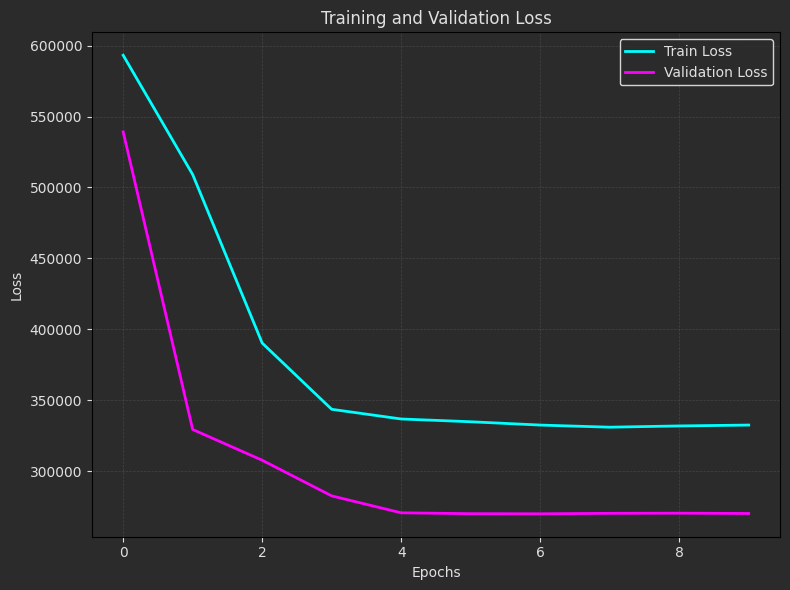

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['loss'], label='Train Loss', color='cyan', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='magenta', linewidth=2)

ax.set_title('Training and Validation Loss', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Loss', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()



In [31]:
from tensorflow.keras.models import load_model


model = load_model("/content/model.h5")


def preprocess_image(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (128, 128))
    image = image / 255.0
    return image


def predict_home_price(image_paths):

    processed_images = [preprocess_image(img) for img in image_paths]
    input_images = np.array(processed_images)
    predicted_prices = model.predict(input_images)
    final_price = np.mean(predicted_prices)

    return final_price



image_paths = ["/content/100_bedroom.jpg", "/content/100_bedroom.jpg", "/content/100_frontal.jpg", "/content/100_kitchen.jpg"]
predicted_price = predict_home_price(image_paths)
print(f"Estimated Home Price: ${predicted_price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Estimated Home Price: $466906.78
